In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
events_raw = np.loadtxt(path + "data/slider-depth/events.txt")

In [4]:
events_ref = flt.filter_refract(events_raw, 0.05)

In [5]:
start_time = 2.5
duration = 0.1
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [6]:
# patch_center = (90, 90)
# patch_size = 180
# shape = (patch_size, patch_size)
# events = flt.filter_patch(events_t, patch_center, patch_size)
events = events_t
shape = (180, 240)
events.shape

(24560, 4)

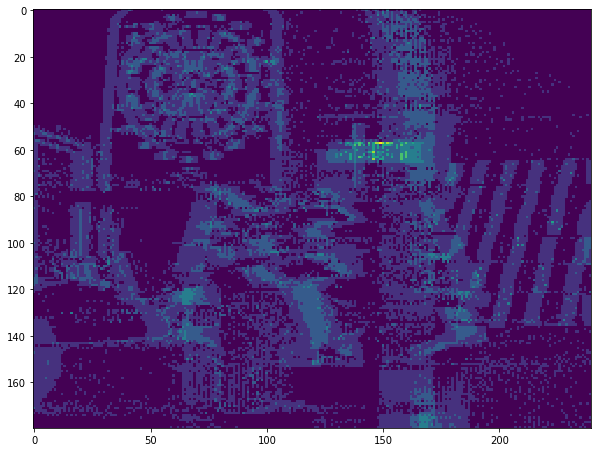

In [7]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(vis.events2img(events, shape, filter_polarity=False), interpolation="none")

In [8]:
warped_shape = (180, 240)
time_diff_dict = td.compute_time_difference_warped(events, shape, start_time, warped_shape)

In [11]:
warped_img, warped_count = td.mean_from_dict(time_diff_dict, warped_shape, 1)

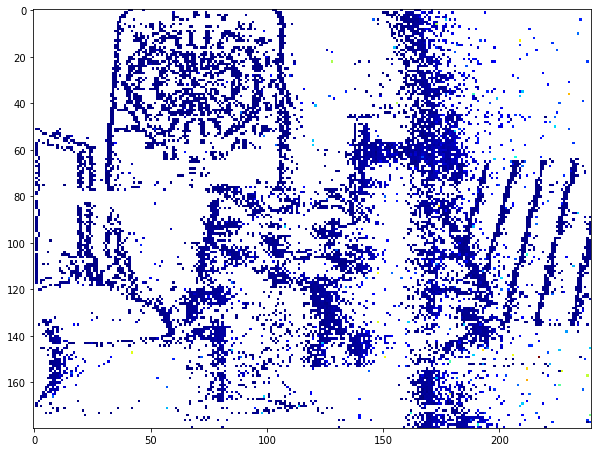

In [12]:
%matplotlib inline
warped_img_m = np.ma.masked_where(warped_img==0, warped_img)
plt.figure(figsize=(10, 10))
plt.imshow(warped_img_m, cmap="jet", interpolation="none");

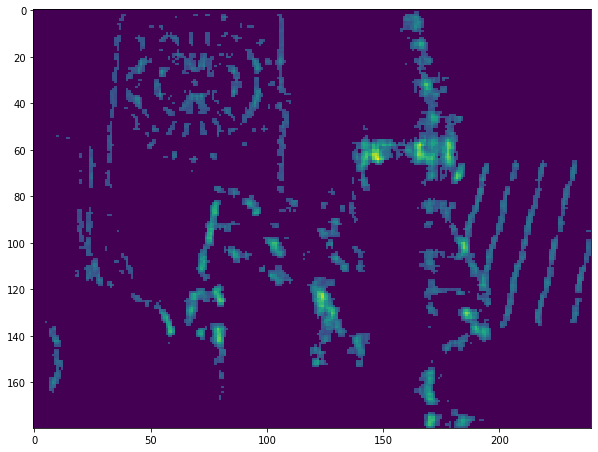

In [53]:
count = np.ma.masked_where(warped_count == 0, warped_count)
count_conv = np.zeros(count.shape)
conv_shape = (3, 3)
d = int(conv_shape[0]/2)
thresh = 10
for x in range(count_conv.shape[1]):
    for y in range(count_conv.shape[0]):
        pxs = count[y-d:y+d+1, x-d:x+d+1]
        c = pxs.data.sum()
        if c >= thresh:
            count_conv[y, x] = pxs.data.sum()

plt.figure(figsize=(10, 10))
plt.imshow(count_conv, interpolation="none")
warped_count_m = np.ma.masked_where(count_conv ==  0, count_conv)

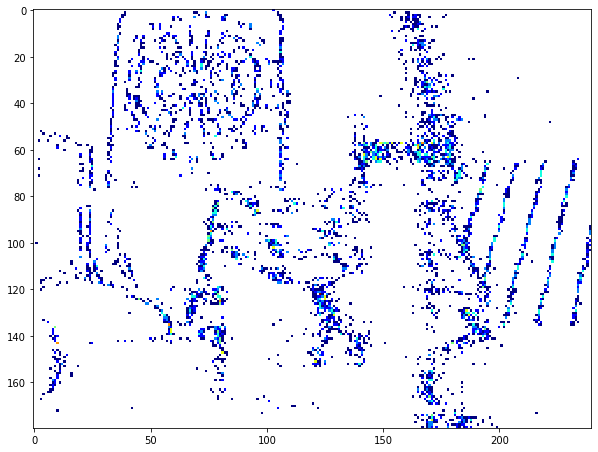

In [16]:
%matplotlib inline
warped_count_m = np.ma.masked_where(warped_count<2, warped_count)
plt.figure(figsize=(10, 10))
plt.imshow(warped_count_m, interpolation="none", cmap="jet");

In [37]:
def adaptive_thresh_filter(img, dist, c):
    result = np.zeros(img.shape)
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            if img.mask[y, x]:
                continue
            if x < dist or x > img.shape[1] - dist or y < dist or y > img.shape[0] - dist:
                continue
                
            area = img[y-dist:y+dist+1,x-dist:x+dist+1]
            avg = area.compressed().sum() / area.compressed().size
            
            if img.data[y, x] < avg - c:
                continue
            
            result[y, x] = img.data[y, x]
                
    return result

In [51]:
warped_thresh = adaptive_thresh_filter(warped_count_m, 10, -5)

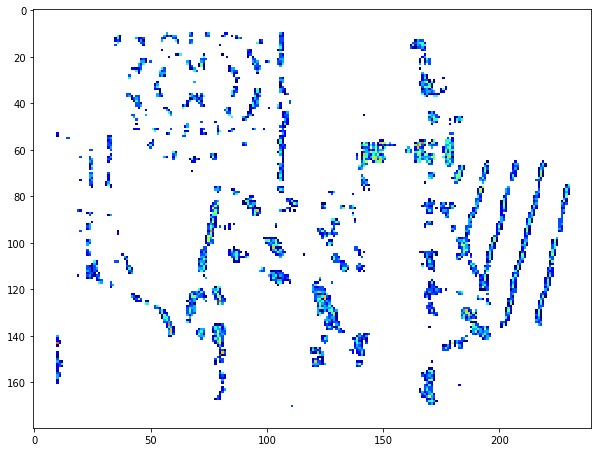

In [52]:
%matplotlib inline
warped_count_m_t = np.ma.masked_where(warped_thresh == 0, warped_count)
plt.figure(figsize=(10, 10))
plt.imshow(warped_count_m_t, interpolation="none", cmap="jet");

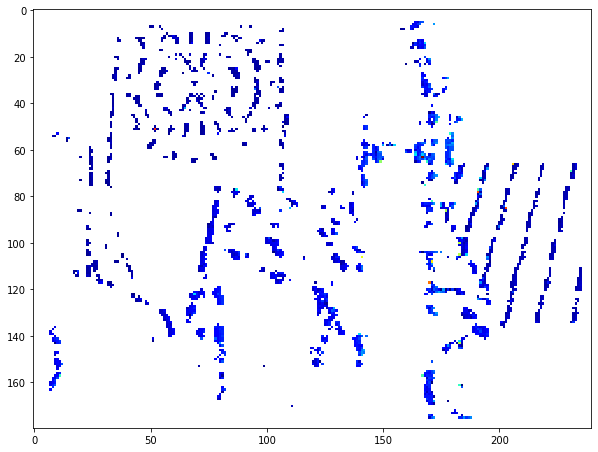

In [40]:
%matplotlib inline
warped_img_m = np.ma.masked_where(np.logical_or(warped_thresh == 0, warped_img == 0), warped_img)
plt.figure(figsize=(10, 10))
plt.imshow(warped_img_m, cmap="jet", interpolation="none")

In [41]:
radius_filt = flt.radius_filter(warped_img_m, 2, 2)

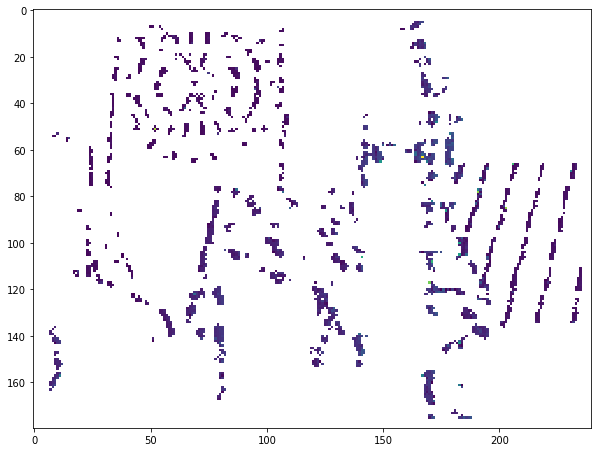

In [42]:
%matplotlib inline
radius_filt_m = np.ma.masked_where(radius_filt == 0, radius_filt)
plt.figure(figsize=(10, 10))
plt.imshow(radius_filt_m, interpolation="none")

In [43]:
median_filt = flt.mean_filter(radius_filt_m, 2)

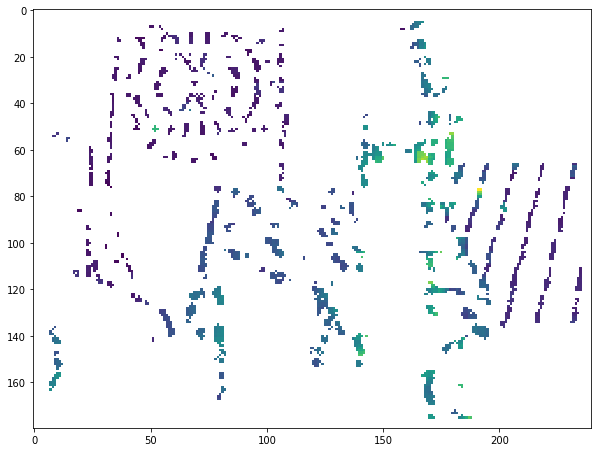

In [44]:
%matplotlib inline
median_filt_m = np.ma.masked_where(median_filt == 0, median_filt)
plt.figure(figsize=(10, 10))
plt.imshow(median_filt_m, interpolation="none")

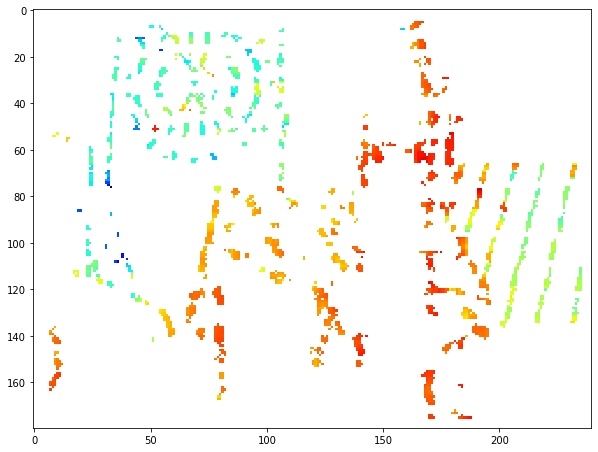

In [45]:
u = median_filt_m

v = 0.2901460156636141
f = 335.419462958

d = np.divide(f, u, where=u>0.0) * v
d = np.ma.masked_where(d <=0, d)
plt.figure(figsize=(10, 10))
m = plt.imshow(d, cmap="jet_r", vmin=0, interpolation="none")
#plt.colorbar(m)

In [205]:
%matplotlib qt
vis.visualize3d(d, s=2, range=(0.0, 3.0))

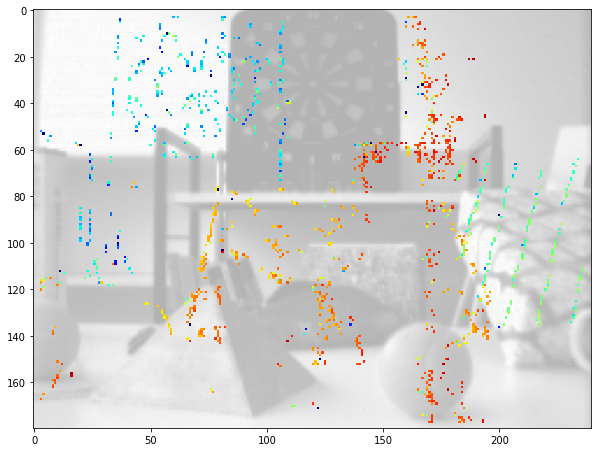

In [206]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img_grey = plt.imread(path + "data/slider-depth/images/frame_00000039.png")
plt.imshow(img_grey, cmap="gray", alpha=0.3)
plt.imshow(d, cmap="jet_r", vmin=0, interpolation="none", vmax=3)

In [207]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")

In [208]:
points = vis._image2pointcloud(d)

In [209]:
K = np.array([
    [calib[0], 0, calib[2]],
    [0, calib[1], calib[3]], 
    [0, 0, 1]
])

In [210]:
gt = np.loadtxt(path + "/data/slider-depth/groundtruth.txt")

In [211]:
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]
t = pose[1:4].reshape(3, 1)
q = pose[4:]

In [212]:
from scipy.spatial.transform import Rotation as R

In [213]:
r = R.from_quat(q)
r_m = r.as_matrix()

In [214]:
r_t = np.hstack((r_m, t))

In [215]:
K_b = np.block([
    [K, np.zeros((3, 1))],
    [np.zeros((1, 3)), 1]
])
rt_b = np.block([
    [r_m, t],
    [np.zeros((1, 3)), 1]
])

In [216]:
proj = []
for p in points:
    if p[2] == 0:
        continue
    po = np.array([p[0], p[1], 1, 1/p[2]])
    test = p[2] * np.linalg.inv(K_b @ rt_b) @ po
    proj.append(test.transpose())

In [217]:
proj = np.array(proj)

In [218]:
proj[0]

array([-1.72789754, -0.30889203,  2.19528898,  1.        ])

In [219]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r", vmin=0.5, vmax=2.5)
ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [220]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

In [221]:
o3d.visualization.draw_geometries([pcd])

In [222]:
proj_d = np.copy(proj)

In [223]:
d_min = proj_d[:,2].min()
d_max = proj_d[:,2].max()
bins = np.linspace(d_min, d_max + 0.1, 50)
proj_d[:,2] = bins[np.digitize(proj_d[:,2], bins)]

In [176]:
pcd = vis.points_to_open3d_pointcloud(proj_d[:,:3])
o3d.visualization.draw_geometries([pcd])

In [155]:
proj_d[:,2]

array([0.95092691, 2.28568724, 2.28568724, ..., 1.5156332 , 1.46429626,
       1.46429626])